# Yelp Restaurant Photos Classification

Yelp held a photo classification competition on Kaggle two years ago. It asked Kagglers
to build a model that automatically tags user-uploaded photos with multiple labels, nine
labels to be exact. In this capstone project, I would be working on designing and
building a Convolutional Neural Network to try to achieve or better the highest
benchmark score. The goal of this project is to assign a set of labels to each photo
correctly. 

## Import Libaries

In [1]:
import os
import math
import pandas as pd
import numpy as np
from IPython.display import display
from keras.preprocessing import image
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras import optimizers
from sklearn.datasets import load_files       
from sklearn.model_selection import train_test_split
from PIL import ImageFile
from matplotlib import pyplot as plt


%matplotlib inline

Using TensorFlow backend.


## Import Datasets

**train_photo_to_biz_ids.csv.tgz** contain the mapping
from each photo to its associated business ID. In other words, this mapping allows a
business to have more than one pictures, and we're able to tell which photos belong to
which store.

**train_photos.tgz** contain the actual photos. Photo ID is in each
photo's file name. All the images are user-uploaded, meaning they are non-uniform in
sizes and color images.

**train.csv.tgz** contains each business ID with its associated correct/truth labels. There are
2000 distinct businesses.

In [2]:
# load train and validation datasets
def load_dataset(path, photos_to_biz, labels, should_split, return_train=True):
    # get filenames
    processed_filenames, processed_labels = [], []
    filenames = os.listdir(path=path)
    for filename in filenames:
        # remove filename that contains underscore
        if '_' not in filename:
            processed_filenames.append(filename)
    
    # delete this line when actually training!!!!!!!!!!!!!!!! only test code works for now
    processed_filenames = processed_filenames[:1000]
    
    # get each photo's target labels
    for filename in processed_filenames:
        bus_id = photos_to_biz.query('train_photo_id=={}'.format(filename.split(".", 1)[0]))['business_id']
        this_labels = labels.query("business_id=={}".format(bus_id.iloc[0]))['labels'].iloc[0]
        
        tmp_labels = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        if isinstance(this_labels, float) and math.isnan(this_labels):
            # empty cell
            pass
        else:
            # multiple labels
            this_labels = this_labels.split(" ")
            for label in this_labels:
                tmp_labels[int(label)] = 1

        processed_labels.append(tmp_labels)
    
    if should_split:
        X_train, X_validation, y_train, y_validation = train_test_split(np.array(processed_filenames), 
                                                                        np.array(processed_labels), 
                                                                        test_size = 0.2, 
                                                                        random_state = 0)
        if return_train:
            return X_train, y_train
        else:    # return validation set
            return X_validation, y_validation
    
    
    # just return filenames and labels
    return np.array(processed_filenames), np.array(processed_labels)


# img_folder = '../'
img_folder = "C:\\Users\\I-Chun Liu\\Documents\\Local_Code\\final_project\\data"

# test_photos_to_biz = pd.read_csv(img_folder + '/test_photo_to_biz.csv.tgz', compression='gzip', sep=',')
# test_photos_to_biz.columns = ['test_photo_id', 'business_id']

train_photo_to_biz_ids = pd.read_csv(img_folder + '/train_photo_to_biz_ids.csv.tgz', compression='gzip', sep=',')
train_photo_to_biz_ids.columns = ['train_photo_id', 'business_id']

train_labels = pd.read_csv(img_folder + '/train.csv.tgz', compression='gzip', sep=',')
train_labels.columns = ['business_id', 'labels']

X_train, y_train = load_dataset(img_folder + '/train_photos', train_photo_to_biz_ids, train_labels, True, True)

In [3]:
# show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))

Training set has 800 samples.


## Pre-process Training Data

In [4]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_filenames):
    list_of_tensors = [path_to_tensor(img_folder + '/train_photos/' + img_filename) for img_filename in img_filenames]
    return np.vstack(list_of_tensors)

In [5]:
train_tensors = paths_to_tensor(X_train).astype('float32')/255
print("Train tenors size: {}".format(train_tensors.shape))

Train tenors size: (800, 224, 224, 3)


### Image Augmentations

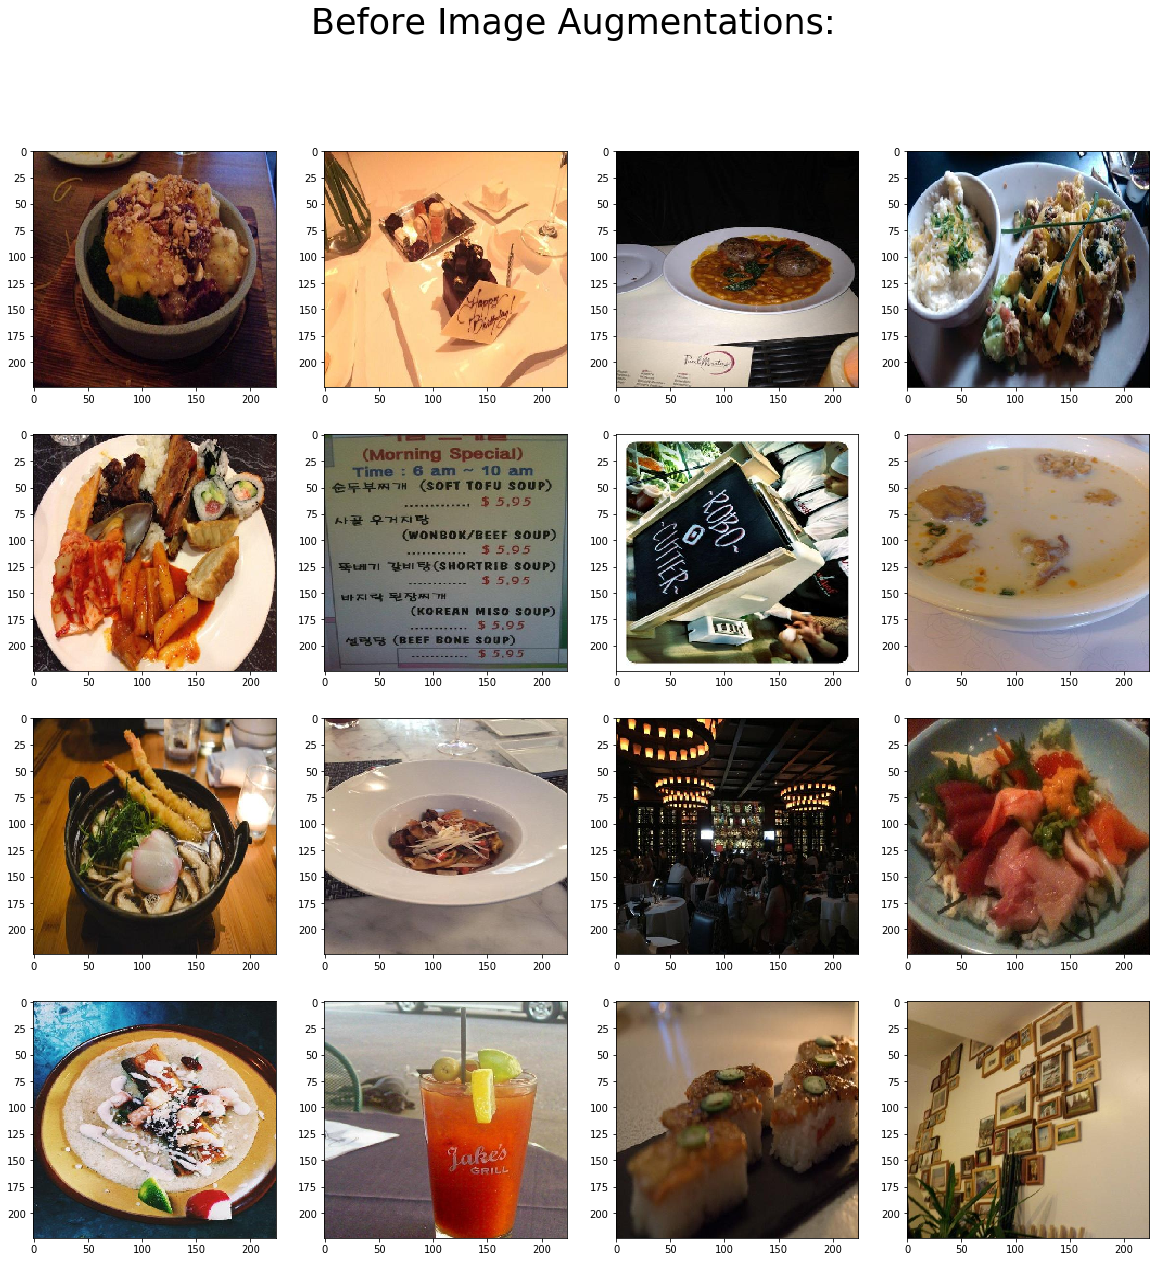

In [6]:
f1, subplots_array_before = plt.subplots(4,4, figsize=(20, 20))
f1.suptitle('Before Image Augmentations:', fontsize=35)
for i in range(0, 16):
    row, col = 0, 0
    for i in range(0, 16):
        if col == 4:
            col = 0
            row += 1

        subplots_array_before[row, col].imshow(train_tensors[i], interpolation='nearest', aspect='auto')
        col += 1

    # show the plot
    plt.show()
    break

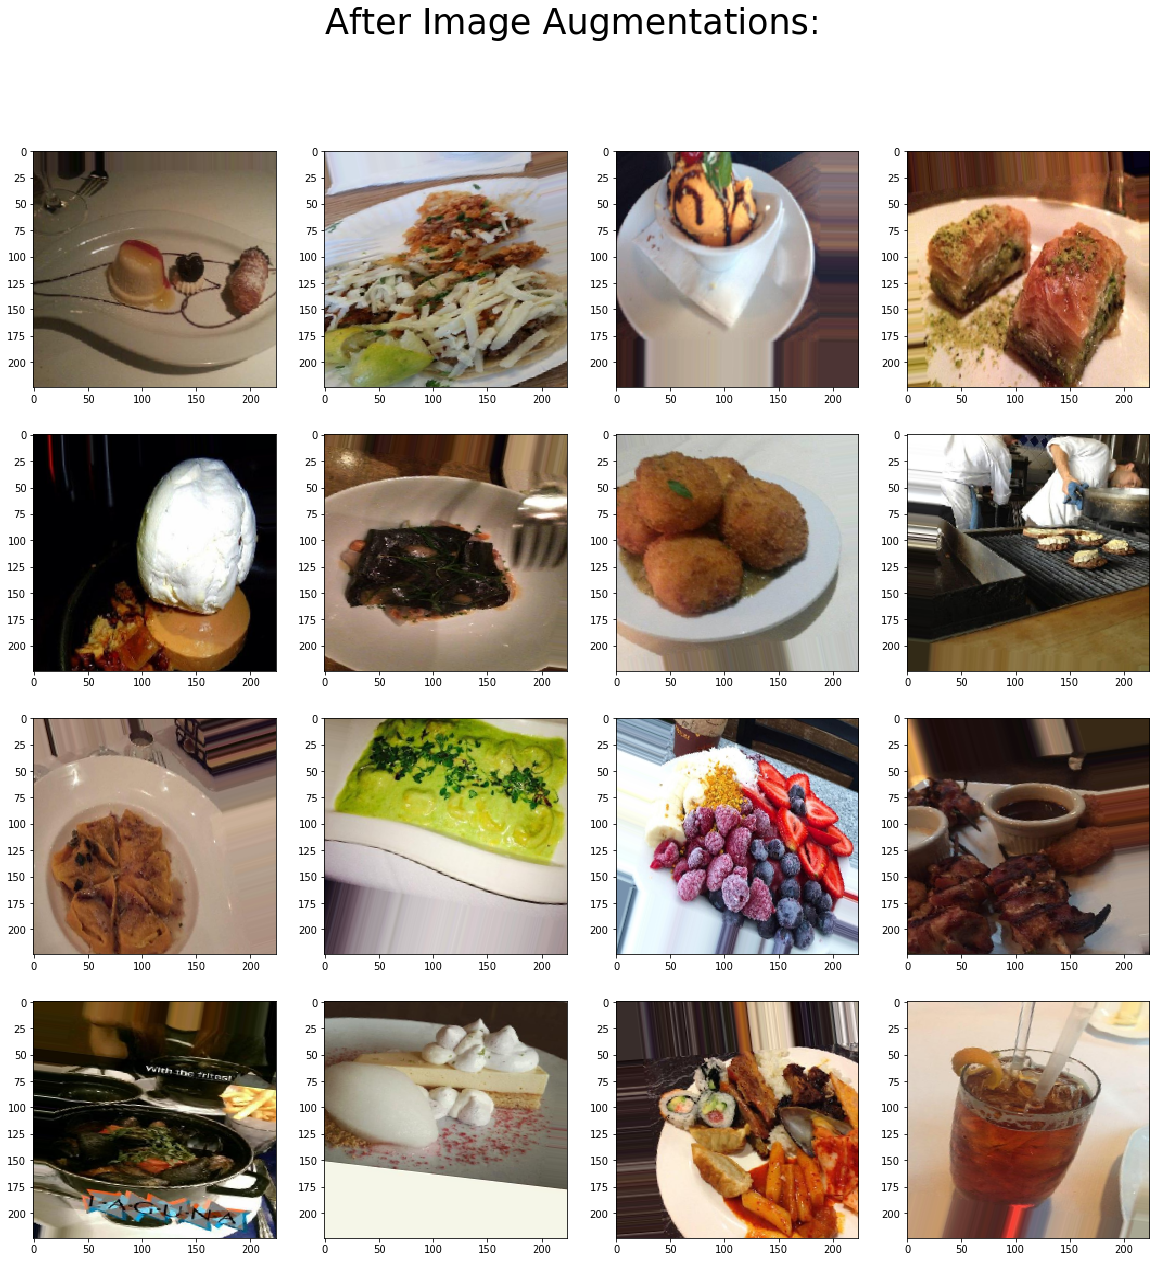

In [7]:
# perform image augmentations
datagen_train = image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.05,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

datagen_train.fit(train_tensors)

f2, subplots_array_after = plt.subplots(4,4, figsize=(20, 20))
f2.suptitle('After Image Augmentations:', fontsize=35)
for X_batch in datagen_train.flow(train_tensors):
    row, col = 0, 0
    for i in range(0, 16):
        if col == 4:
            col = 0
            row += 1

        subplots_array_after[row, col].imshow(X_batch[i], interpolation='nearest', aspect='auto')
        col += 1

    # show the plot
    plt.show()
    break

In [8]:
from extract_bottleneck_features import *

train_features = extract_Resnet50(train_tensors * 255)

print("Train features shape: {}".format(train_features.shape))

np.save('./bottleneck_features/Resnet50_train', train_features)

processing tensor...
extracting features using Resnet50...


c:\users\i-chun liu\anaconda3\envs\cuda10\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Train features shape: (800, 7, 7, 2048)


## Pre-process / Feature Extraction of Validation Data

Do the same image pre-processing and bottleneck features extraction for validation set:

In [9]:
X_validation, y_validation = load_dataset(img_folder + '/train_photos', train_photo_to_biz_ids, train_labels, True, False)

print("Validation set has {} samples.".format(X_validation.shape[0]))

validation_tensors = paths_to_tensor(X_validation).astype('float32')/255
print("Validation tenors size: {}".format(validation_tensors.shape))

# image pre-processing
datagen_validation = image.ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.05,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')
datagen_validation.fit(validation_tensors)

validation_features = extract_Resnet50(validation_tensors * 255)

print("Validation features shape: {}".format(validation_features.shape))

np.save('./bottleneck_features/Resnet50_validation', validation_features)

Validation set has 200 samples.
Validation tenors size: (200, 224, 224, 3)
processing tensor...
extracting features using Resnet50...
Validation features shape: (200, 7, 7, 2048)


# Create / Train the Model 

In [10]:
# Load bottleneck features
train_features = np.load('./bottleneck_features/Resnet50_train.npy')
validation_features = np.load('./bottleneck_features/Resnet50_validation.npy')

print("Train features shape: {}".format(train_features.shape))
print("Validation features shape: {}".format(validation_features.shape))

Train features shape: (800, 7, 7, 2048)
Validation features shape: (200, 7, 7, 2048)


In [11]:
epochs = 20
batch_size = 32 

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit(train_features, y_train, epochs=epochs, batch_size=batch_size, validation_data=(validation_features, y_validation), verbose=2, shuffle=True)

Train on 800 samples, validate on 200 samples
Epoch 1/20
 - 2s - loss: 11.9292 - acc: 0.1125 - val_loss: 11.2329 - val_acc: 0.1650
Epoch 2/20
 - 0s - loss: 10.7983 - acc: 0.1063 - val_loss: 11.1467 - val_acc: 0.0550
Epoch 3/20
 - 0s - loss: 10.4145 - acc: 0.1363 - val_loss: 11.1545 - val_acc: 0.0750
Epoch 4/20
 - 0s - loss: 10.2360 - acc: 0.1562 - val_loss: 11.1673 - val_acc: 0.1100
Epoch 5/20
 - 0s - loss: 10.1016 - acc: 0.1675 - val_loss: 11.4497 - val_acc: 0.1250
Epoch 6/20
 - 0s - loss: 10.0054 - acc: 0.1487 - val_loss: 11.2650 - val_acc: 0.1750
Epoch 7/20
 - 0s - loss: 9.8634 - acc: 0.1787 - val_loss: 11.0834 - val_acc: 0.1250
Epoch 8/20
 - 0s - loss: 9.7704 - acc: 0.1850 - val_loss: 11.5002 - val_acc: 0.1950
Epoch 9/20
 - 0s - loss: 9.6419 - acc: 0.1925 - val_loss: 11.4083 - val_acc: 0.0300
Epoch 10/20
 - 0s - loss: 9.6650 - acc: 0.1738 - val_loss: 11.5312 - val_acc: 0.0500
Epoch 11/20
 - 0s - loss: 9.5257 - acc: 0.1738 - val_loss: 11.4318 - val_acc: 0.0650
Epoch 12/20
 - 0s - lo

In [12]:
model.predict(validation_features)[0]

array([0.01433259, 0.03111411, 0.10121687, 0.10527782, 0.09731715,
       0.1433122 , 0.38567656, 0.09494775, 0.02680499], dtype=float32)

# References
1. How to use pretrained model in Keras: https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/


In [13]:
model.predict(validation_features)[190]

array([0.06209899, 0.04716006, 0.05785242, 0.13340001, 0.07901719,
       0.09867128, 0.30399823, 0.16004138, 0.05776039], dtype=float32)

In [14]:
model.evaluate(validation_features, y_validation, verbose=2)

[11.661579208374024, 0.07]